In [1]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
from typing import List

import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose



In [25]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=imagenet",
            # "compute.distributed=False",
            "model=resnet50",
            # "model=skinny_resnet18",
            "rigl.dense_allocation=0.05",
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)


resnet50


In [3]:
def reinit_ablated_neuron_count(pruner: RigLConstFanScheduler) -> RigLConstFanScheduler:
    pruner.dynamically_ablated_neuron_idx = [
            [x for x in list(range(len(layer))) if x not in layer]
            for layer in pruner.active_neurons
        ]
    return pruner

In [34]:
params = {k:[] for k in ["dense_allocation", "parameters", "dense_params"]}
for da in [0.01, 0.05, 0.0625, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5,]:
    checkpoint=None
    rank=1

    if checkpoint is not None:
        run_id = checkpoint.run_id
        optimizer_state = checkpoint.optimizer
        scheduler_state = checkpoint.scheduler
        pruner_state = checkpoint.pruner
        model_state = checkpoint.model
        cfg = checkpoint.cfg
    else:
        run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
            None,
            None,
            None,
            None,
            None,
        )

    print(cfg.compute)
    cfg.compute.distributed=False
        
    pl.seed_everything(cfg.training.seed)
    use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
    if not use_cuda:
        raise SystemError("GPU has stopped responding...waiting to die!")
        logger.warning(
            "Using CPU! Verify cfg.compute.no_cuda and "
            "torch.cuda.is_available() are properly set if this is unexpected"
        )

    if cfg.compute.distributed and use_cuda:
        device = torch.device(f"cuda:{rank}")
    else:
        print(f"loading to device rank: {rank}")
        device = torch.device(f"cuda:{rank}")
    if not use_cuda:
        device = torch.device("cuda" if use_cuda else "cpu")
    # train_loader, test_loader = get_dataloaders(cfg)

    model = ModelFactory.load_model(
        model=cfg.model.name, dataset=cfg.dataset.name, diet=cfg.rigl.diet
    )
    model.to(device)
    if cfg.compute.distributed:
        model = DistributedDataParallel(model, device_ids=[rank])
    if model_state is not None:
        try:
            model.load_state_dict(model_state)
        except RuntimeError:
            model_state = checkpoint.get_single_process_model_state_from_distributed_state()
            model.load_state_dict(model_state)
            
    optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
    scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
    pruner = None
    if cfg.rigl.dense_allocation is not None:
        if cfg.rigl.dense_allocation is not None:
            if cfg.model.name == "skinny_resnet18":
                dense_allocation = (
                    cfg.rigl.dense_allocation * cfg.model.sparsity_scale_factor
                )
                print(
                    f"Scaling {cfg.rigl.dense_allocation} by "
                    f"{cfg.model.sparsity_scale_factor:.2f} for SkinnyResNet18 "
                    f"New Dense Alloc == {dense_allocation:.6f}"
                )
            else:
                dense_allocation = cfg.rigl.dense_allocation
            T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
            if cfg.rigl.const_fan_in:
                rigl_scheduler = RigLConstFanScheduler
            else:
                rigl_scheduler = RigLScheduler
            pruner = rigl_scheduler(
                model,
                optimizer,
                dense_allocation=da,
                alpha=cfg.rigl.alpha,
                delta=cfg.rigl.delta,
                static_topo=cfg.rigl.static_topo,
                T_end=T_end,
                ignore_linear_layers=cfg.rigl.ignore_linear_layers,
                grad_accumulation_n=cfg.rigl.grad_accumulation_n,
                sparsity_distribution=cfg.rigl.sparsity_distribution,
                erk_power_scale=cfg.rigl.erk_power_scale,
                state_dict=pruner_state,
                filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
                static_ablation=cfg.rigl.static_ablation,
                dynamic_ablation=cfg.rigl.dynamic_ablation,
                min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
                use_sparse_init=cfg.rigl.use_sparse_initialization,
                init_method_str=cfg.rigl.init_method_str,
                use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
            )
            step=0
    print(f"Results for {1-da} sparsity...")
    els = []
    non_zero=[]
    for p in model.parameters():
        els.append(p.numel())
        non_zero.append(torch.count_nonzero(p))
    s=torch.tensor(non_zero).sum().item()
    n=torch.tensor(els).sum().item()
    w_total = torch.tensor([torch.count_nonzero(w) for w in pruner.W]).sum()
    params["dense_allocation"].append(da)
    params["parameters"].append(s)
    params["dense_params"].append(n)
    # print(f"total el: {n}")
    # print(f"non zero el: {s}")
    # print(f"non zero weights only: {w_total}")
    # print(s/n)

Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f5a9bebf910> with args: () and kwargs: {'diet': [17, 16, 17, 14, 16, 33, 31, 31, 32, 30, 65, 63, 63, 65, 63, 122, 124, 124, 114, 125, 0]}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f5a9bebf910> with args: () and kwargs: {'diet': [17, 16, 17, 14, 16, 33, 31, 31, 32, 30, 65, 63, 63, 65, 63, 122, 124, 124, 114, 125, 0]}


Results for 0.99 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f5a9bebf910> with args: () and kwargs: {'diet': [17, 16, 17, 14, 16, 33, 31, 31, 32, 30, 65, 63, 63, 65, 63, 122, 124, 124, 114, 125, 0]}


Results for 0.95 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f5a9bebf910> with args: () and kwargs: {'diet': [17, 16, 17, 14, 16, 33, 31, 31, 32, 30, 65, 63, 63, 65, 63, 122, 124, 124, 114, 125, 0]}


Results for 0.9375 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f5a9bebf910> with args: () and kwargs: {'diet': [17, 16, 17, 14, 16, 33, 31, 31, 32, 30, 65, 63, 63, 65, 63, 122, 124, 124, 114, 125, 0]}


Results for 0.9 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 3 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 4 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 5 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 7 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 8 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 10 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 11 set to 0.0
Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using 

Results for 0.8 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 3 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 4 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 5 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 7 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 8 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 10 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 11 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 13 set to 0.0
INFO:/home/user/condensed

Results for 0.75 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 3 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 4 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 5 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 7 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 8 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 10 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 11 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 13 set to 0.0
INFO:/home/user/condensed

Results for 0.7 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 3 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 4 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 5 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 7 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 8 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 10 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 11 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 13 set to 0.0
INFO:/home/user/condensed

Results for 0.6 sparsity...
{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 1


INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 1 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 3 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 4 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 5 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 7 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 8 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 10 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 11 set to 0.0
INFO:/home/user/condensed-sparsity/src/rigl_torch/rigl_scheduler.py:Sparsity of layer at index 13 set to 0.0
INFO:/home/user/condensed

Results for 0.5 sparsity...


In [35]:
import pandas as pd
pd.DataFrame(params).to_dict()

{'dense_allocation': {0: 0.01,
  1: 0.05,
  2: 0.0625,
  3: 0.1,
  4: 0.2,
  5: 0.25,
  6: 0.3,
  7: 0.4,
  8: 0.5},
 'parameters': {0: 274072,
  1: 1289784,
  2: 1611784,
  3: 2571656,
  4: 5113920,
  5: 6391944,
  6: 7663032,
  7: 10222975,
  8: 12774296},
 'dense_params': {0: 25557032,
  1: 25557032,
  2: 25557032,
  3: 25557032,
  4: 25557032,
  5: 25557032,
  6: 25557032,
  7: 25557032,
  8: 25557032}}

In [ ]:
"""
Results for 0.95 sparsity...
total el: 25557032
non zero el: 1289784
non zero weights only: 1262224
0.05046689302576293

Results for 0.9375 sparsity...
total el: 25557032
non zero el: 1611784
non zero weights only: 1584224
0.06306616511651275

Results for 0.19999999999999996 sparsity...
total el: 25557032
non zero el: 20427879
non zero weights only: 20400319
0.7993056079438332
"""

In [ ]:
# RES50 - 93.75%
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
w_total = torch.tensor([torch.count_nonzero(w) for w in pruner.W]).sum()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(f"non zero weights only: {w_total}")
print(s/n)


In [13]:
# RES50 - 100%
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 25557032
non zero el: 25530471
0.9989607165652099


In [16]:
# RES50 - 75%
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 25557032
non zero el: 6391944
0.25010509827588745


In [27]:
# RES50 - 93.75%
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
w_total = torch.tensor([torch.count_nonzero(w) for w in pruner.W]).sum()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(f"non zero weights only: {w_total}")
print(s/n)


total el: 25557032
non zero el: 1289784
non zero weights only: 1262224
0.05046689302576293


In [24]:
torch.tensor([torch.count_nonzero(w) for w in pruner.W]).sum()

tensor(1584224)

In [ ]:
19152999

In [13]:
# ADJUSTED SPARSITY SKINNY RESNET18
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 6628793
non zero el: 560246
0.08451704556168822


In [16]:
# RESNET18
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 11173962
non zero el: 560522
0.05016322768951604


In [56]:
11173962/6628793 = 1.6856706794132807

1.6856706794132807

In [38]:
# skinny
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 6628793
non zero el: 68494
0.01033280116003019


In [54]:
# skinny adjusted
els = []
non_zero=[]
for p in model.parameters():
    els.append(p.numel())
    non_zero.append(torch.count_nonzero(p))
s=torch.tensor(non_zero).sum().item()
n=torch.tensor(els).sum().item()
print(f"total el: {n}")
print(f"non zero el: {s}")
print(s/n)


total el: 6628793
non zero el: 114115
0.017215049557287428


In [21]:
run_id = "us1p7psr" 
rank=0
#  resnet18 0.01 0.5
runs = ['26t97fyn', 'f75f6a5m', '2jjmdzam', 'tkcz3emd','37my33se']
runs = ['f75f6a5m', '2jjmdzam', 'tkcz3emd','37my33se']
diets = []
for run_id in runs:
    dir = "/home/user/condensed-sparsity/artifacts/checkpoints/for_anna_2/resnet18-99-50/"
    checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir=dir)
    # checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir = cfg.paths.checkpoints)
    # print(checkpoint)
    # checkpoint=None
    if checkpoint is not None:
        run_id = checkpoint.run_id
        optimizer_state = checkpoint.optimizer
        scheduler_state = checkpoint.scheduler
        pruner_state = checkpoint.pruner
        model_state = checkpoint.model
        cfg = checkpoint.cfg
    else:
        run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
            None,
            None,
            None,
            None,
            None,
        )

    print(cfg.compute)
    cfg.compute.distributed=False
        
    pl.seed_everything(cfg.training.seed)
    use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
    if not use_cuda:
        raise SystemError("GPU has stopped responding...waiting to die!")
        logger.warning(
            "Using CPU! Verify cfg.compute.no_cuda and "
            "torch.cuda.is_available() are properly set if this is unexpected"
        )

    if cfg.compute.distributed and use_cuda:
        device = torch.device(f"cuda:{rank}")
    else:
        print(f"loading to device rank: {rank}")
        device = torch.device(f"cuda:{rank}")
    if not use_cuda:
        device = torch.device("cuda" if use_cuda else "cpu")
    # train_loader, test_loader = get_dataloaders(cfg)

    model = ModelFactory.load_model(
        model=cfg.model.name, dataset=cfg.dataset.name
    )
    model.to(device)
    if cfg.compute.distributed:
        model = DistributedDataParallel(model, device_ids=[rank])
    if model_state is not None:
        try:
            model.load_state_dict(model_state)
        except RuntimeError:
            model_state = checkpoint.get_single_process_model_state_from_distributed_state()
            model.load_state_dict(model_state)
            
    optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
    scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
    pruner = None
    if cfg.rigl.dense_allocation is not None:
        T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
        if cfg.rigl.const_fan_in:
            rigl_scheduler = RigLConstFanScheduler
        else:
            rigl_scheduler = RigLScheduler
        pruner = rigl_scheduler(
            model,
            optimizer,
            dense_allocation=cfg.rigl.dense_allocation,
            alpha=cfg.rigl.alpha,
            delta=cfg.rigl.delta,
            static_topo=cfg.rigl.static_topo,
            T_end=T_end,
            ignore_linear_layers=cfg.rigl.ignore_linear_layers,
            grad_accumulation_n=cfg.rigl.grad_accumulation_n,
            sparsity_distribution=cfg.rigl.sparsity_distribution,
            erk_power_scale=cfg.rigl.erk_power_scale,
            state_dict=pruner_state,
            filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
            static_ablation=cfg.rigl.static_ablation,
            dynamic_ablation=cfg.rigl.dynamic_ablation,
            min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
            use_sparse_init=cfg.rigl.use_sparse_initialization,
            init_method_str=cfg.rigl.init_method_str,
            use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
        )
        
        step=0

    pruner = reinit_ablated_neuron_count(pruner)
    diet = [len(d) for d in pruner.dynamically_ablated_neuron_idx]
    diets.append(diet)

    
    # checkpoint = Checkpoint(
    #             run_id=run_id,
    #             cfg=cfg,
    #             model=model,
    #             optimizer=optimizer,
    #             scheduler=scheduler,
    #             pruner=pruner,
    #             epoch=0,
    #             step=step,
    #             parent_dir=cfg.paths.checkpoints,
    #         )

    

INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/user/condensed-sparsity/artifacts/checkpoints/for_anna_2/resnet18-99-50/20230112_f75f6a5m/checkpoint.pt.tar...
Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x7fb59595d090> with args: () and kwargs: {}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/user/condensed-sparsity/artifacts/checkpoints/for_anna_2/resnet18-99-50/20230112_2jjmdzam/checkpoint.pt.tar...
Global seed set to 2078
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x7fb59595d090> with args: () and kwargs: {}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/user/condensed-sparsity/artifacts/checkpoints/for_anna_2/resnet18-99-50/20230112_tkcz3emd/checkpoint.pt.tar...
Global seed set to 7303
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x7fb59595d090> with args: () and kwargs: {}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/user/condensed-sparsity/artifacts/checkpoints/for_anna_2/resnet18-99-50/20230112_37my33se/checkpoint.pt.tar...
Global seed set to 6037
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x7fb59595d090> with args: () and kwargs: {}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


In [23]:
torch.tensor(pruner.N).sum()

tensor(11164352)

In [ ]:
torch.tensor()and

In [10]:
torch.tensor(diets)[:,0]

tensor([16, 19, 18, 16])

In [11]:
diet

[16,
 15,
 17,
 13,
 17,
 31,
 29,
 30,
 31,
 27,
 59,
 56,
 58,
 63,
 58,
 119,
 121,
 120,
 115,
 125,
 0]

In [61]:
torch.tensor(diets, dtype=torch.float).mean(dim=0).type(dtype=torch.int).tolist()

[17,
 16,
 17,
 14,
 16,
 33,
 31,
 31,
 32,
 30,
 65,
 63,
 63,
 65,
 63,
 122,
 124,
 124,
 114,
 125,
 0]

In [60]:
torch.tensor([[1.9]], dtype=torch.float).type(dtype=torch.int)

tensor([[1]], dtype=torch.int32)

In [54]:
torch.tensor(diets, dtype=torch.float).mean(dim=0).tolist()

[17.399999618530273,
 16.399999618530273,
 17.200000762939453,
 14.600000381469727,
 16.200000762939453,
 33.400001525878906,
 31.200000762939453,
 31.200000762939453,
 32.400001525878906,
 30.399999618530273,
 65.19999694824219,
 63.0,
 63.20000076293945,
 65.0,
 63.0,
 122.19999694824219,
 124.4000015258789,
 124.4000015258789,
 114.0,
 125.0,
 0.0]

In [34]:
print(pruner)

RigLScheduler(
layers=21,
nonzero_params=[864/1728, 1624/36864, 1628/36864, 1617/36864, 1610/36864, 2400/73728, 3116/147456, 2325/8192, 3136/147456, 3124/147456, 4704/294912, 6256/589824, 4655/32768, 6272/589824, 6300/589824, 9292/1179648, 12420/2359296, 9360/131072, 12506/2359296, 12444/2359296, 5120/5120],
nonzero_percentages=[50.00%, 4.41%, 4.42%, 4.39%, 4.37%, 3.26%, 2.11%, 28.38%, 2.13%, 2.12%, 1.60%, 1.06%, 14.21%, 1.06%, 1.07%, 0.79%, 0.53%, 7.14%, 0.53%, 0.53%, 100.00%],
total_nonzero_params=110773/11164352 (0.99%),
total_CONV_nonzero_params=105653/11159232 (0.95%),
step=97500,
num_rigl_steps=731,
ignoring_linear_layers=False,
sparsity_distribution=erk,
ITOP rate=0.2386,
Active Neuron Count=[(32, 64), (29, 64), (37, 64), (33, 64), (35, 64), (60, 128), (76, 128), (75, 128), (64, 128), (71, 128), (112, 256), (136, 256), (133, 256), (112, 256), (105, 256), (202, 512), (207, 512), (208, 512), (169, 512), (204, 512), (10, 10)],
constant fan ins=[27, 56, 44, 49, 46, 40, 41, 31, 49, 4

In [5]:
from rigl_torch.utils.rigl_utils import get_names_and_W
names, W = get_names_and_W(model)
ablated = [0, 22, 20, 26, 18, 51, 34, 0, 56, 38, 114, 102, 64, 114, 121, 248, 223, 218, 286, 221, 0]
len(W) == len(ablated) == len(names)

True

In [20]:
[len(w) for w in W]

[64,
 64,
 64,
 64,
 64,
 128,
 128,
 128,
 128,
 128,
 256,
 256,
 256,
 256,
 256,
 512,
 512,
 512,
 512,
 512,
 10]

In [19]:
names


['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.shortcut.0',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.shortcut.0',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.shortcut.0',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'linear']

In [20]:
import torch.nn as nn
from typing import Optional

class SkinnyBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels , stride, skip_conn_input_channels: Optional[int]=None ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels=out_channels[0],
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.conv2 = nn.Conv2d(
            out_channels[0], out_channels[1], kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels[1])

        self.shortcut = nn.Sequential()
        if skip_conn_input_channels is not None:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    out_channels[1],
                    skip_conn_input_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(skip_conn_input_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SkinnyResNet18(nn.Module):
    def __init__(self, full_width_network: nn.Module, diet: List[int], num_blocks: List[int], num_classes=10):
        super().__init__()
        self.num_blocks=num_blocks
        self.names, full_w = get_names_and_W(full_width_network)
        self.diet = diet
        self.full_width = [len(w) for w in full_w]
        self.width = [fw-d for fw,d in list(zip(self.full_width, self.diet))]
        self._in_channel_idx=0
        
        self.conv1 = nn.Conv2d(
            3, self.width[0], kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.width[0])
        self.layer1 = self._make_layer(
                num_blocks=self.num_blocks[0],
                stride=1,
            )
        self.layer2 = self._make_layer(
            num_blocks=self.num_blocks[0],
                stride=2,
            )
        self.layer3 = self._make_layer(
            num_blocks=self.num_blocks[0],
                stride=2,
            )
        self.layer4 = self._make_layer(
            num_blocks=self.num_blocks[0],

                stride=2
            )
        self.linear = nn.Linear(self.width[-1] * SkinnyBlock.expansion, num_classes)
        _, skinny_w = get_names_and_W(self)
        assert [len(w) for w in skinny_w] == self.width
        
    @property
    def _block_start_idx(self):
        return self._in_channel_idx+1
    
    def _make_layer(self, num_blocks, stride):
        strides: List[int] = [stride] + [1] * (num_blocks - 1)
        layers=[]
        in_channels = self.width[self._in_channel_idx]
        
        for stride in strides:
            skip_conn_input_channels=None
            if stride != 1:
                skip_conn_input_channels=self.width[self._block_start_idx+num_blocks]
            layers.append(
                SkinnyBlock(
                    self.width[self._in_channel_idx],
                    self.width[self._block_start_idx:self._block_start_idx+num_blocks],
                    stride=stride, 
                    skip_conn_input_channels=skip_conn_input_channels,
                )
            )
            if skip_conn_input_channels is None:
                # We only need to move index num blocks away
                self._in_channel_idx+=num_blocks 
            else:
                # Else we need to move past this layers skip conn too
                self._in_channel_idx+=num_blocks+1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    
model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name
)
                          
from rigl_torch.utils.rigl_utils import get_names_and_W
names, W = get_names_and_W(model)
ablated = [0, 22, 20, 26, 18, 51, 34, 0, 56, 38, 114, 102, 64, 114, 121, 248, 223, 218, 286, 221, 0]
len(W) == len(ablated) == len(names)
[len(w) for w in W]

net = SkinnyResNet18(
    full_width_network=model,
    diet=ablated,
    num_blocks=[2,2,2,2]
)


INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x7f07ecf001f0> with args: () and kwargs: {}


In [ ]:
net.train()
for batch_idx, (data, target) in enumerate(train_loader):
    

In [45]:
pruner.W[0].shape

torch.Size([64, 3, 3, 3])

In [87]:
discon = pruner.backward_masks[1][17]

In [89]:
pruner.backward_masks[2].shape

torch.Size([64, 64, 3, 3])

In [91]:
pruner.backward_masks[2][:,17].any()

tensor(False, device='cuda:0')

In [95]:
pruner.backward_masks[0].shape

torch.Size([64, 3, 3, 3])

In [96]:
len(pruner.W[0])

64

In [118]:
pruner.backward_masks[0].shape

torch.Size([64, 3, 3, 3])

In [119]:
shortcut_increment = 1 
for layer_idx, w in enumerate(pruner.W):
    if pruner.backward_masks[layer_idx+1].shape[1] != w.shape[0]:
        print("inc short")
        shortcut_increment+=1
    for n_idx, n in enumerate(w):
        if not n.any():
            print(layer_idx, n_idx)
            print(f"disconnected at {layer_idx+1 ,n_idx}? {not pruner.backward_masks[layer_idx+shortcut_increment][:,n_idx].any()}")
            

1 17
disconnected at (2, 17)? True
1 19
disconnected at (2, 19)? True
1 25
disconnected at (2, 25)? True
1 32
disconnected at (2, 32)? True
1 36
disconnected at (2, 36)? True
1 40
disconnected at (2, 40)? True
1 49
disconnected at (2, 49)? True
1 55
disconnected at (2, 55)? True
1 60
disconnected at (2, 60)? True
2 8
disconnected at (3, 8)? True
2 25
disconnected at (3, 25)? True
2 40
disconnected at (3, 40)? True
2 61
disconnected at (3, 61)? True
3 3
disconnected at (4, 3)? True
3 5
disconnected at (4, 5)? True
3 16
disconnected at (4, 16)? True
3 25
disconnected at (4, 25)? True
3 38
disconnected at (4, 38)? True
3 42
disconnected at (4, 42)? True
3 45
disconnected at (4, 45)? True
3 49
disconnected at (4, 49)? True
3 52
disconnected at (4, 52)? True
4 32
disconnected at (5, 32)? True
4 40
disconnected at (5, 40)? True
4 59
disconnected at (5, 59)? True
5 6
disconnected at (6, 6)? True
5 10
disconnected at (6, 10)? True
5 17
disconnected at (6, 17)? True
5 28
disconnected at (6, 28)

IndexError: index 134 is out of bounds for dimension 1 with size 128

In [114]:
t = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3))

In [115]:
t._parameters["weight"].shape

torch.Size([64, 3, 3, 3])

In [103]:
pruner.W[6].shape

torch.Size([128, 128, 3, 3])

In [102]:
pruner.W[7].shape

torch.Size([128, 64, 1, 1])

In [49]:
torch.count_nonzero(pruner.W[0][0])

tensor(13, device='cuda:0')

In [52]:
pruner.backward_masks[0][0].sum()

tensor(13, device='cuda:0')

In [59]:
for n in pruner.W[0]:
    if torch.count_nonzero(n) == 0:
        print(n)

In [60]:
ablated = []
for layer_idx, layer in enumerate(pruner.W):
    layer_ablated = []
    for n_idx, n in enumerate(layer):
        if torch.count_nonzero(pruner.W[layer_idx][n_idx]) == 0:
            layer_ablated.append(n_idx)
    ablated.append(layer_ablated)
print([len(a) for a in ablated])

[0, 9, 4, 9, 3, 23, 9, 0, 23, 11, 53, 19, 12, 51, 24, 108, 69, 53, 92, 53, 0]


In [71]:
torch.Tensor([not n.any() for n in pruner.W[0]]).sum()

tensor(0.)

tensor(736, device='cuda:0')

In [ ]:
print(pruner.W[0])

In [17]:
[ [torch.count_nonzero(n) for n in layer] for layer in pruner.W ]

[[tensor(13, device='cuda:0'),
  tensor(6, device='cuda:0'),
  tensor(11, device='cuda:0'),
  tensor(12, device='cuda:0'),
  tensor(6, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(9, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(7, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(8, device='cuda:0'),
  tensor(12, device='cuda:0'),
  tensor(12, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(12, device='cuda:0'),
  tensor(8, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(7, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(3, device='cuda:0'),
  tensor(13, device='cuda:0'),
  tensor(12, dev

In [ ]:
for layer in pruner.W:
    total = []
    for n

In [46]:
pruner.backward_masks[0].sum()

tensor(832, device='cuda:0')

In [47]:
torch.count_nonzero(pruner.W[0])

tensor(736, device='cuda:0')

In [48]:
for idx, neuron in enumerate(pruner.W[0]):
    print(idx)
    print(torch.count_nonzero(neuron))

0
tensor(13, device='cuda:0')
1
tensor(6, device='cuda:0')
2
tensor(11, device='cuda:0')
3
tensor(12, device='cuda:0')
4
tensor(6, device='cuda:0')
5
tensor(13, device='cuda:0')
6
tensor(9, device='cuda:0')
7
tensor(13, device='cuda:0')
8
tensor(13, device='cuda:0')
9
tensor(13, device='cuda:0')
10
tensor(7, device='cuda:0')
11
tensor(13, device='cuda:0')
12
tensor(13, device='cuda:0')
13
tensor(8, device='cuda:0')
14
tensor(12, device='cuda:0')
15
tensor(12, device='cuda:0')
16
tensor(13, device='cuda:0')
17
tensor(12, device='cuda:0')
18
tensor(8, device='cuda:0')
19
tensor(13, device='cuda:0')
20
tensor(7, device='cuda:0')
21
tensor(13, device='cuda:0')
22
tensor(13, device='cuda:0')
23
tensor(13, device='cuda:0')
24
tensor(13, device='cuda:0')
25
tensor(13, device='cuda:0')
26
tensor(13, device='cuda:0')
27
tensor(13, device='cuda:0')
28
tensor(13, device='cuda:0')
29
tensor(13, device='cuda:0')
30
tensor(3, device='cuda:0')
31
tensor(13, device='cuda:0')
32
tensor(12, device='cuda

In [4]:
for mask in pruner.backward_masks:
    for neuron in 

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [54]:
pruner = reinit_ablated_neuron_count(pruner)
# pruner.dynamically_ablated_neuron_idx

In [53]:
def reinit_ablated_neuron_count(pruner: RigLConstFanScheduler) -> RigLConstFanScheduler:
    pruner.dynamically_ablated_neuron_idx=dynamically_ablated_neurons = [ [x for x in list(range(len(layer))) if x not in layer] for layer in pruner.active_neurons]
    for layer_idx, layer in enumerate(pruner.dynamically_ablated_neuron_idx):
        for neuron_idx in layer:
            assert not pruner.backward_masks[layer_idx][neuron_idx].any()
            assert (pruner.W[layer_idx][neuron_idx]==0).all()
    return pruner



In [31]:
for x in dynamically_ablated_neurons[0]:
    if x in pruner.active_neurons[0]:
        print("uhoh")

In [39]:
pruner.active_neurons[3]

[2,
 4,
 6,
 7,
 8,
 10,
 12,
 13,
 16,
 17,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 35,
 36,
 39,
 41,
 44,
 45,
 46,
 57,
 58,
 59,
 61]

In [28]:
[ [x for x in list(range(len(layer))) if x not in layer] for layer in pruner.active_neurons]

[[0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 18, 19, 20, 22, 23, 25, 30],
 [0, 1, 3, 5, 6, 7, 8, 10, 15, 19, 21, 22, 23, 24, 25, 26],
 [0, 2, 3, 4, 6, 8, 12, 14, 17, 18, 20, 21, 22, 23, 25, 28, 30, 34],
 [0, 1, 3, 5, 9, 11, 14, 15, 18, 19, 23, 32],
 [0, 2, 4, 6, 8, 9, 10, 12, 14, 15, 18, 21, 23, 27, 28, 29, 30],
 [0,
  2,
  6,
  8,
  10,
  13,
  15,
  21,
  23,
  24,
  25,
  26,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  40,
  42,
  43,
  45,
  46,
  47,
  48,
  49,
  51,
  55,
  56,
  57,
  58],
 [1,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  16,
  17,
  22,
  24,
  28,
  31,
  34,
  36,
  39,
  41,
  51,
  52,
  54,
  56,
  57,
  58,
  60,
  62,
  67,
  68,
  69,
  73],
 [1,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  16,
  17,
  22,
  24,
  28,
  31,
  34,
  36,
  38,
  39,
  41,
  42,
  51,
  52,
  54,
  56,
  57,
  58,
  60,
  67,
  68],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  10,
  13,
  14,
  15,
  17,
  22,
  24,
  25,
  28,
  31,
  32,
  35,
  36,
  38,
  41,
  47,
  50,
  51,
 

In [26]:
print(pruner)

RigLScheduler(
layers=21,
nonzero_params=[864/1728, 1624/36864, 1628/36864, 1617/36864, 1610/36864, 2400/73728, 3116/147456, 2325/8192, 3136/147456, 3124/147456, 4704/294912, 6256/589824, 4655/32768, 6272/589824, 6300/589824, 9292/1179648, 12420/2359296, 9360/131072, 12506/2359296, 12444/2359296, 5120/5120],
nonzero_percentages=[50.00%, 4.41%, 4.42%, 4.39%, 4.37%, 3.26%, 2.11%, 28.38%, 2.13%, 2.12%, 1.60%, 1.06%, 14.21%, 1.06%, 1.07%, 0.79%, 0.53%, 7.14%, 0.53%, 0.53%, 100.00%],
total_nonzero_params=110773/11164352 (0.99%),
total_CONV_nonzero_params=105653/11159232 (0.95%),
step=97500,
num_rigl_steps=731,
ignoring_linear_layers=False,
sparsity_distribution=erk,
ITOP rate=0.2386,
Active Neuron Count=[(32, 64), (29, 64), (37, 64), (33, 64), (35, 64), (60, 128), (76, 128), (75, 128), (64, 128), (71, 128), (112, 256), (136, 256), (133, 256), (112, 256), (105, 256), (202, 512), (207, 512), (208, 512), (169, 512), (204, 512), (10, 10)],
constant fan ins=[27, 56, 44, 49, 46, 40, 41, 31, 49, 4

In [24]:
# def add_dynamic_ablated_neuron_idx = 


# pruner.dynamically_ablated_neuron_idx  = [[list(range(x)) for x in] for layer_idx, layer in enumerate(pruner.active_neurons)]

In [5]:
pruner.W[0].numel()

9408

In [12]:
torch.count_nonzero(pruner.W[0])

tensor(384, device='cuda:0')

In [7]:
pruner.S[0]

0.9580298609954484

In [6]:
pruner.N[0]

9408

In [11]:
1- pruner.backward_masks[0].sum() / pruner.W[0].numel()

tensor(0.9592, device='cuda:0')

In [14]:
1-384/9408

0.9591836734693877

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "


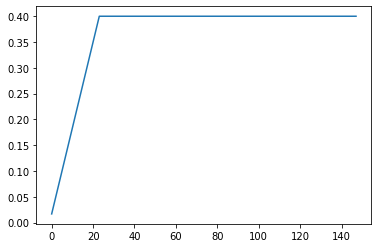

In [4]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(1,149)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [5]:
scheduler_state_dict, optimizer_state_dict = checkpoint.get_state()["scheduler"], checkpoint.get_state()["optimizer"]

INFO:rigl_torch.utils.checkpoint:New best checkpoint accuracy (0.000000 > -inf)!


In [6]:
new_optim = get_optimizer(cfg, model, optimizer_state_dict)
ckp_scheduler= get_lr_scheduler(cfg, new_optim, state_dict=scheduler_state_dict)

Loading optimizer from checkpoint...


In [7]:
ckp_scheduler.state_dict()

{'step_size': [150, 350, 450],
 'warm_up_steps': 25,
 'gamma': 0.1,
 'lr': 0.4,
 '_linear_warmup_lrs': array([1.00000000e-06, 1.66676250e-02, 3.33342500e-02, 5.00008750e-02,
        6.66675000e-02, 8.33341250e-02, 1.00000750e-01, 1.16667375e-01,
        1.33334000e-01, 1.50000625e-01, 1.66667250e-01, 1.83333875e-01,
        2.00000500e-01, 2.16667125e-01, 2.33333750e-01, 2.50000375e-01,
        2.66667000e-01, 2.83333625e-01, 3.00000250e-01, 3.16666875e-01,
        3.33333500e-01, 3.50000125e-01, 3.66666750e-01, 3.83333375e-01,
        4.00000000e-01]),
 '_logger': <Logger /home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py (INFO)>,
 'base_lrs': [0.4],
 'last_epoch': 148,
 '_step_count': 149,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.4]}

INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.04000000000000001 @ epoch 150
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.004000000000000001 @ epoch 350
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00040000000000000013 @ epoch 450


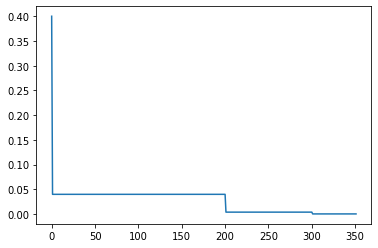

In [9]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(149,501)):
    ckp_scheduler.step()
    lrs.append(ckp_scheduler.get_last_lr())

plt.plot(lrs)

In [13]:
ckp_scheduler.__dict__

{'step_size': [150, 350, 450],
 'warm_up_steps': 25,
 'gamma': 0.1,
 'lr': 0.4,
 '_linear_warmup_lrs': array([1.00000000e-06, 1.66676250e-02, 3.33342500e-02, 5.00008750e-02,
        6.66675000e-02, 8.33341250e-02, 1.00000750e-01, 1.16667375e-01,
        1.33334000e-01, 1.50000625e-01, 1.66667250e-01, 1.83333875e-01,
        2.00000500e-01, 2.16667125e-01, 2.33333750e-01, 2.50000375e-01,
        2.66667000e-01, 2.83333625e-01, 3.00000250e-01, 3.16666875e-01,
        3.33333500e-01, 3.50000125e-01, 3.66666750e-01, 3.83333375e-01,
        4.00000000e-01]),
 '_logger': <Logger /home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py (INFO)>,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     initial_lr: 0.4
     lr: 1e-06
     maximize: False
     momentum: 0.9
     nesterov: True
     weight_decay: 0.0001
 ),
 'base_lrs': [0.4],
 'last_epoch': 148,
 '_step_count': 149,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_l

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.04000000000000001 @ epoch 150
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.004000000000000001 @ epoch 350
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00040000000000000013 @ epoch 450


[[0.016667625000000002], [0.03333425], [0.050000875], [0.0666675], [0.08333412500000001], [0.10000075], [0.116667375], [0.133334], [0.150000625], [0.16666725000000002], [0.183333875], [0.2000005], [0.21666712500000002], [0.23333375], [0.250000375], [0.266667], [0.283333625], [0.30000024999999997], [0.316666875], [0.3333335], [0.350000125], [0.36666675], [0.383333375], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4],

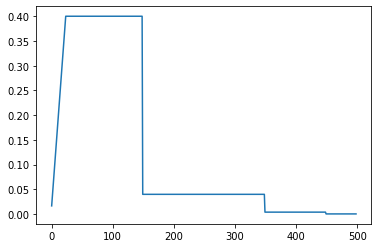

In [17]:
import matplotlib.pyplot as plt

lrs = []
for epoch in list(range(1,150)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
print(lrs)
plt.plot(lrs)

In [5]:
pruner.__str__()

'RigLScheduler(\nlayers=54,\nnonzero_params=[384/9408, 576/4096, 640/36864, 1536/16384, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1792/32768, 1152/147456, 3072/65536, 3584/131072, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3584/131072, 2304/589824, 6144/262144, 7168/524288, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 7168/524288, 4608/2359296, 12288/1048576, 14336/2097152, 12288/1048576, 4608/2359296, 12288/1048576, 12288/1048576, 4608/2359296, 12288/1048576, 14000/2048000],\nnonzero_percentages=[4.08%, 14.06%, 1.74%, 9.38%, 9.38%, 9.38%, 1.74%, 9.38%, 9.38%, 1.74%, 9.38%, 5.47%, 0.78%, 4.69%, 2.73%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 2.73%, 0.39%, 2.34%, 1.37%, 2.34%, 0.39%, 2.34%, 2.34%, 0.39%, 2.34%, 

In [18]:
# net = ModelFactory.load_model("wide_resnet22", "cifar10")
model = ModelFactory.load_model("resnet50", "imagenet")
device = torch.device("cuda:0")
train_loader, test_loader = get_dataloaders(cfg)
# model = ModelFactory.load_model(
#         model=cfg.model.name, dataset=cfg.dataset.name
#     )
model.to(device)
optimizer = get_optimizer(cfg, model, state_dict=None)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=None)
T_end = get_T_end(cfg, train_loader)
if cfg.rigl.const_fan_in:
    rigl_scheduler = RigLConstFanScheduler
else:
    rigl_scheduler = RigLScheduler
# pruner = rigl_scheduler(
#     model,
#     optimizer,
#     dense_allocation=cfg.rigl.dense_allocation,
#     alpha=cfg.rigl.alpha,
#     delta=cfg.rigl.delta,
#     static_topo=cfg.rigl.static_topo,
#     T_end=T_end,
#     ignore_linear_layers=False,
#     grad_accumulation_n=cfg.rigl.grad_accumulation_n,
#     sparsity_distribution=cfg.rigl.sparsity_distribution,
#     erk_power_scale=cfg.rigl.erk_power_scale,
#     state_dict=None,
#     filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
#     static_ablation=cfg.rigl.static_ablation,
#     dynamic_ablation=cfg.rigl.dynamic_ablation,
#     min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,
#     )

INFO:/project/6066928/mklasby/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f808c85ac10> with args: () and kwargs: {}


Files already downloaded and verified


In [ ]:
pruner(
    
)